## Keypoint MoSeq 

#### This notebook illustrates how fit a keypoint-SLDS model on pose tracking data (e.g. from DeepLabCut)

- Make sure keypoint_moseq is [installed](XXX)
- Change the kernel to `keypoint_moseq`
- Download the [example data](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link)


In [1]:
from jax.config import config
config.update('jax_enable_x64', True)
import keypoint_moseq as kpm

### Setup a new project
- Edit `project_dir` and `dlc_config` as necessary
- This step creates a new directory with a `config.yml` file

In [2]:
project_dir = 'demo_project'

# option 1: set up from scratch
# kpm.setup_project(project_dir)

# option 2: set up from deeplabcut
dlc_config = 'moseq_example-caleb-2022-11-09/config.yaml'
kpm.setup_project(project_dir, deeplabcut_config=dlc_config)

# define config loader
config = lambda: kpm.load_config(project_dir)

The directory `demo_project` already exists. Use `overwrite=True` or
pick a different name for the project directory


### Edit the config file

- The config can be edited manually or using `kpm.update_config`, as shown below.
- The cell below contains all config edits necessary for the rest of the notebook. 

In general, the following parameters should be specified for each project..

- `bodyparts` (The name of each keypoint; automatically imported if you setup from DLC)
- `use_bodyparts` (Subset of bodyparts to use for modeling; defaults to all if you setup from DLC)
- `anterior_bodyparts` and `posterior_bodyparts` (Used for rotational alignment)
- `video_dir` (directory with videos of each experiment; detaults to `[DLC project path]/videos` if you setup from DLC.


In [3]:
kpm.update_config(
    project_dir,
    video_dir = 'moseq_example-caleb-2022-11-09/videos',
    use_bodyparts=['spine4','spine3','spine2','spine1','head','nose','right ear','left ear'],
    anterior_bodyparts=['nose'], posterior_bodyparts=['spine4'],
    latent_dimension=4, slope= -0.47, intercept= 0.236721)

### Load data

- `coordinates` is a dict of (T,K,D) arrays where K is the number of keypoints and D is 2 or 3. 
- `confidences` is a dict of (T,K) arrays of **nonzero** confidence scores for each keypoint.

If applying keypoint-MoSeq to your own data, note that:
- `confidences` are optional (they are used to set the error prior for each observation)
- if importing from DLC, data are assumed to be .h5/.csv files in `video_dir`)
- each key in `coordinates` should start with its video name 
    - e.g. `coordinates["experiment1etc"]` would correspond to `experiment1.avi`
    - in general this will already be true if importing from DLC

In [4]:
# load data from DLC
coordinates,confidences = kpm.load_keypoints_from_deeplabcut(**config())

# format for modeling (reshapes into fixed-length batches and moves to GPU)
data,batch_info = kpm.format_data(coordinates, confidences=confidences, **config())

Searching in moseq_example-caleb-2022-11-09/videos. Use the
``directory`` argument to specify another search location


Loading from deeplabcut: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


### Calibrate 

The purpose of calibration is to learn the relationship between error and keypoint confidence scores. The resulting regression coefficients (`slope` and `intercept`) are used during modeling to set the noise prior on a per-frame, per-keypoint basis. One can also adjust the `confidence_threshold` parameter at this step, which is used to define outlier keypoints for PCA and model initialization. **This step can be skipped for the demo data** since the config already includes suitable regression coefficients.

- Run the cell below. A widget should appear with a video frame in the center.
    - *If the widget doesn't render, try using jupyter lab rather instead of jupyter notebook*
    

- Annotate the each frame with the correct location of the labeled bodypart
    - Left click to specify the correct location - an "X" should appear.
    - Use the arrow buttons and/or sample slider on the left to annotate additional frames.
    - Each annotation adds a point to the right-hand plot. Continue until the regression line stabilizes.
    
    
- At any point, adjust the confidence threshold by clicking on the right-hand plot.


- **Use the "save" button to update the config and store your annotations to disk**.

In [ ]:
kpm.noise_calibration(project_dir, coordinates, confidences, **config())

### Fit PCA

Run the cell below to fit a PCA model to aligned keypoint coordinates. After fitting, two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC. 

- After fitting, edit `latent_dimension` in the config. A good heuristic is the number needed to explain 90% of variance. 
- If your computer crashes at this step, try lowering `PCA_fitting_num_frames` in the config.

PCA: Interpolating low-confidence detections
PCA: Performing egocentric alignment
PCA: Fitting PCA model on 645711 sample poses
>=90.0% of variance exlained by 4 components.


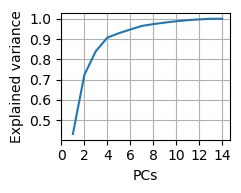

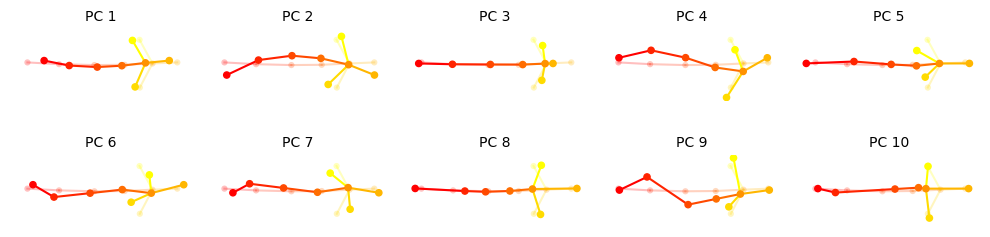

In [5]:
# uncomment if you have already fit pca
# pca = kpm.load_pca(project_dir)

pca = kpm.fit_pca(**data, **config())
kpm.save_pca(pca, project_dir)

kpm.print_dims_to_explain_variance(pca, 0.9)
kpm.plot_scree(pca, project_dir=project_dir)
kpm.plot_pcs(pca, project_dir=project_dir, **config())

### Initialize and fit model (AR-HMM)

In [ ]:
model = kpm.initialize_model(pca=pca, **data, **config())

In [ ]:
model,history,name = kpm.fit_model(model, data, batch_info, ar_only=True, 
                                   num_iters=50, project_dir=project_dir)

### Reload snapshot and continue fitting (KP-SLDS)

In [ ]:
checkpoint = kpm.load_checkpoint(project_dir=project_dir, name=name)

checkpoint['hypparams']['trans_hypparams']['kappa'] = 7e4

checkpoint = kpm.revert(checkpoint, 50)

model,history,name = kpm.resume_fitting(**checkpoint, project_dir=project_dir, 
                                        ar_only=False, num_iters=200)


### Apply the model to generate a final set of state sequences

In [ ]:
checkpoint = kpm.load_checkpoint(project_dir=project_dir, name=name)

results_dict = kpm.apply_model(coordinates=coordinates, confidences=confidences, 
                               project_dir=project_dir, **checkpoint, **config())

### Visualize results

In [ ]:
# generate plots showing the average keypoint trajectories for each syllable
kpm.generate_trajectory_plots(coordinates, name=name, project_dir=project_dir, **config())

In [ ]:
# generate video clips for each syllable
kpm.generate_crowd_movies(name=name, project_dir=project_dir, **config())